In [1]:
# Import Pandas, Numpy, and Datetime modules for basic data manipulations
import pandas as pd
import numpy as np
import datetime as dt

# Use Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Import several modules from Scikit-learn for conducting and evaluating K-means clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_excel('data.xlsx', sheet_name='Year 2009-2010')

In [3]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


# Data Preparation

In [4]:
# Check which column has NA and if data type is suitable for use
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
# List out all the countries
df.Country.value_counts()

United Kingdom          485852
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76
Israel  

In [6]:
# Here we only focus on the local customers, i.e. from United Kingdom
df = df[df['Country'] == 'United Kingdom'].copy()

In [7]:
# Drop column Country to save computing power
df.drop(columns=['Country'], inplace=True)

In [8]:
# Notice that there are Null values in Customer ID column. Let's check what they are
df[df['Customer ID'].isnull() == True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN
...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN


In [9]:
# If other records with same invoice number indicate the customer IDs, we can fill in these empty cells.
# Let's check if we can do so 
invoice_wo_ID = df[df['Customer ID'].isnull() == True]['Invoice']
invoice_w_ID = df[df['Customer ID'].isnull() == False]['Invoice']
invoice_wo_ID.isin(invoice_w_ID).any()

False

In [10]:
# Unfortunately, we can't find customer IDs from other entries. So these rows are useless, we have to drop them 
df.dropna(subset=['Customer ID'], axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379423 entries, 0 to 525460
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      379423 non-null  object        
 1   StockCode    379423 non-null  object        
 2   Description  379423 non-null  object        
 3   Quantity     379423 non-null  int64         
 4   InvoiceDate  379423 non-null  datetime64[ns]
 5   Price        379423 non-null  float64       
 6   Customer ID  379423 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 23.2+ MB


In [11]:
# change data type of Customer ID to int
df['Customer ID'] = df['Customer ID'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379423 entries, 0 to 525460
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      379423 non-null  object        
 1   StockCode    379423 non-null  object        
 2   Description  379423 non-null  object        
 3   Quantity     379423 non-null  int64         
 4   InvoiceDate  379423 non-null  datetime64[ns]
 5   Price        379423 non-null  float64       
 6   Customer ID  379423 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 23.2+ MB


In [12]:
# check the range of the numeric values. We notice that there are values with negative quantity 
df.describe()

,Quantity,Price,Customer ID
count,379423.000000,379423.000000,379423.000000
mean,11.451517,3.653249,15559.935694
std,68.943709,68.743746,1593.744626
min,-9360.000000,0.000000,12346.000000
25%,2.000000,1.250000,14210.000000
50%,4.000000,1.950000,15581.000000
75%,12.000000,3.750000,16938.000000
max,10000.000000,25111.090000,18287.000000


In [13]:
# Let's see what exactly they are. 
df[df['Quantity'] <= 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592
197,C489459,90200D,PINK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592
198,C489459,90200B,BLACK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592
199,C489459,90200E,GREEN SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592
200,C489459,90200C,BLUE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592
...,...,...,...,...,...,...,...
524692,C538122,22444,GROW YOUR OWN PLANT IN A CAN,-1,2010-12-09 15:38:00,1.25,14696
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329


In [14]:
# All the invoice with negative quantity starts with letter C. Looks like they are canceling existing transactions 
# Let's try to learn the meaning of different types of Stock Code used in this data set. 
# We achieve this by examing the Stock Code in different code length. Let's create a new column to store the length 
df['LenOfCode'] = df['StockCode'].apply(str).str.len()
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5


In [15]:
df[df['LenOfCode'] == 1]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299,1
736,C489535,D,Discount,-1,2009-12-01 12:11:00,19.00,15299,1
3053,C489651,M,Manual,-1,2009-12-01 16:48:00,5.10,17804,1
9259,C490126,M,Manual,-1,2009-12-03 18:12:00,5.95,15884,1
9307,C490129,M,Manual,-1,2009-12-03 18:26:00,1998.49,15482,1
...,...,...,...,...,...,...,...,...
521122,537804,M,Manual,12,2010-12-08 13:17:00,2.95,12748,1
521124,537804,M,Manual,12,2010-12-08 13:17:00,0.19,12748,1
522330,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340,1
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,1


In [16]:
df[df['LenOfCode'] == 1].loc[:,['StockCode', 'Description']].value_counts()

StockCode  Description
M          Manual         550
D          Discount        90
dtype: int64

In [17]:
df[df['LenOfCode'] == 2]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
19541,490998,C2,CARRIAGE,1,2009-12-08 17:24:00,50.0,16253,2
34330,492250,C2,CARRIAGE,1,2009-12-16 10:45:00,50.0,18286,2
44683,493308,C2,CARRIAGE,1,2009-12-22 16:17:00,50.0,15064,2
93664,498149,C2,CARRIAGE,1,2010-02-17 10:24:00,50.0,18285,2
110926,500010,C2,CARRIAGE,1,2010-03-04 10:06:00,50.0,13377,2
117005,C500494,C2,CARRIAGE,-1,2010-03-08 12:59:00,50.0,13377,2
132855,501960,C2,CARRIAGE,1,2010-03-22 12:10:00,50.0,14817,2
159719,504621,C2,CARRIAGE,1,2010-04-15 11:47:00,50.0,14944,2
161981,504873,C2,CARRIAGE,1,2010-04-18 12:36:00,50.0,14817,2
167678,505228,C2,CARRIAGE,1,2010-04-21 10:34:00,50.0,16256,2


In [18]:
df[df['LenOfCode'] == 3]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode


In [19]:
df[df['LenOfCode'] == 4]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
927,C489538,POST,POSTAGE,-1,2009-12-01 12:18:00,9.580,15796,4
9103,C490117,POST,POSTAGE,-1,2009-12-03 17:38:00,2.990,16570,4
17617,490806,POST,POSTAGE,1,2009-12-08 12:13:00,4.000,13485,4
25641,C491623,POST,POSTAGE,-1,2009-12-11 14:20:00,15.000,16253,4
29888,491958,POST,POSTAGE,1,2009-12-14 16:10:00,5.000,13577,4
...,...,...,...,...,...,...,...,...
451344,532301,POST,POSTAGE,1,2010-11-11 14:04:00,4.950,16827,4
464104,C533151,POST,POSTAGE,-1,2010-11-16 13:53:00,5.000,13597,4
468280,533528,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-11-17 15:08:00,0.001,15750,4
487592,C534945,POST,POSTAGE,-1,2010-11-24 15:29:00,1.170,17677,4


In [20]:
df[df['LenOfCode'] == 4].loc[:,['StockCode', 'Description']].value_counts()

StockCode  Description               
POST       POSTAGE                       60
PADS       PADS TO MATCH ALL CUSHIONS    14
dtype: int64

In [21]:
df[df['LenOfCode'] == 5]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,5
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085,5
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5


In [22]:
np.where(df[df['LenOfCode'] == 5]['StockCode'] == int, True, False).any()

False

In [23]:
code6 = df[df['LenOfCode'] == 6]
code6

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078,6
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078,6
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078,6
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969,6
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969,6
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969,6
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530,6


In [24]:
code6[~ df[df['LenOfCode'] == 6]['StockCode'].str.contains(r'[0-9]+[A-Za-z]+')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
70979,C495737,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:23:00,10.50,16154,6
70981,C495740,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:24:00,14.00,13054,6
70983,C495739,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:24:00,10.50,15383,6
70986,C495741,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:25:00,13.14,16840,6
71036,C495751,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:28:00,26.19,12858,6
71038,495755,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:29:00,342.80,14413,6
71039,495753,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:29:00,178.31,14653,6
71040,495754,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:29:00,15.58,12846,6
71041,C495757,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:30:00,10.49,16575,6
71045,C495761,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:31:00,13.14,13664,6


In [25]:
code7 = df[df['LenOfCode'] == 7]
code7

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
572,489522,79323LP,LIGHT PINK CHERRY LIGHTS,1,2009-12-01 11:45:00,6.75,15998,7
1762,C489588,79323GR,GREEN CHERRY LIGHTS,-2,2009-12-01 14:01:00,6.75,13711,7
3142,489658,15056BL,EDWARDIAN PARASOL BLACK,12,2009-12-01 17:31:00,5.95,15485,7
3158,489658,79323LP,LIGHT PINK CHERRY LIGHTS,6,2009-12-01 17:31:00,6.75,15485,7
3173,489664,79323GR,GREEN CHERRY LIGHTS,2,2009-12-01 18:03:00,6.75,14061,7
...,...,...,...,...,...,...,...,...
510051,536989,15056BL,EDWARDIAN PARASOL BLACK,1,2010-12-03 15:10:00,5.95,17238,7
510415,537042,15056BL,EDWARDIAN PARASOL BLACK,1,2010-12-05 10:45:00,5.95,13838,7
510727,537055,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-05 11:45:00,5.95,16814,7
517766,537622,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-07 14:30:00,5.95,13173,7


In [26]:
code7[~ df[df['LenOfCode'] == 7]['StockCode'].str.contains(r'[0-9]+[A-Za-z]+')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346,7
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,12346,7
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346,7
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,12346,7
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,12346,7
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346,7
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346,7
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,12346,7
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,12346,7
89084,497819,TEST001,This is a test product.,5,2010-02-12 14:58:00,0.00,14103,7


#### Summary of all non-product codes
Stock Code | Description
--------| ---------
M | Manual
D | Discount
C2 | CARRIAGE
POST | POSTAGE
ADJUST | Adjustment
ADJUST2 | Adjustment
TEST001 | This is a test product
TEST002 | This is a test product 

In [27]:
# Remove test products from the set 
df.drop(df[df['StockCode'] == 'TEST001'].index, inplace=True)
df.drop(df[df['StockCode'] == 'TEST002'].index, inplace=True)

In [28]:
df[(df['StockCode'] == 'TEST001') | (df['StockCode'] == 'TEST002')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode


### Remove cancelled transactions 

In [29]:
# create a table of all the entries with non-positive quantity
non_positive = df[df['Quantity'] <= 0].copy()
non_positive

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,6
197,C489459,90200D,PINK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,6
198,C489459,90200B,BLACK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,6
199,C489459,90200E,GREEN SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,6
200,C489459,90200C,BLUE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,6
...,...,...,...,...,...,...,...,...
524692,C538122,22444,GROW YOUR OWN PLANT IN A CAN,-1,2010-12-09 15:38:00,1.25,14696,5
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,1
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,5
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,5


In [30]:
# create a table of all the entries with positive quantity
positive = df[df['Quantity'] > 0].copy()
positive

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5


In [31]:
non_positive['Inverse Quant'] = - non_positive['Quantity']

In [32]:
merged = positive.merge(non_positive, 
                       left_on=('StockCode', 'Description', 'Quantity', 'Price', 'Customer ID'),
                       right_on=('StockCode', 'Description', 'Inverse Quant', 'Price', 'Customer ID'),
                       how='left',
                       validate='m:m')
merged

,Invoice_x,StockCode,Description,Quantity_x,InvoiceDate_x,Price,Customer ID,LenOfCode_x,Invoice_y,Quantity_y,InvoiceDate_y,LenOfCode_y,Inverse Quant
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5,NaN,NaN,NaT,NaN,NaN
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6,NaN,NaN,NaT,NaN,NaN
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6,NaN,NaN,NaT,NaN,NaN
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5,NaN,NaN,NaT,NaN,NaN
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371344,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5,NaN,NaN,NaT,NaN,NaN
371345,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5,NaN,NaN,NaT,NaN,NaN
371346,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5,NaN,NaN,NaT,NaN,NaN
371347,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5,NaN,NaN,NaT,NaN,NaN


In [33]:
merged.drop(merged[merged['Invoice_y'].isnull() == False].index, inplace=True)

In [34]:
merged.drop(columns=['Invoice_y', 'Quantity_y', 'InvoiceDate_y', 'LenOfCode_y', 'Inverse Quant'],
            inplace=True)

In [35]:
merged

,Invoice_x,StockCode,Description,Quantity_x,InvoiceDate_x,Price,Customer ID,LenOfCode_x
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5
...,...,...,...,...,...,...,...,...
371344,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5
371345,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
371346,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
371347,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5


In [36]:
merged.rename(columns={'Invoice_x': 'Invoice',
                       'Quantity_x': 'Quantity',
                       'InvoiceDate_x': 'InvoiceDate',
                       'LenOfCode_x': 'LenOfCode'},
             inplace=True)
merged

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5
...,...,...,...,...,...,...,...,...
371344,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5
371345,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
371346,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5
371347,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5


# Calculate RFM value

In [37]:
# Calculate sales value for each row and store the value in a new column 
merged['Revenue'] = merged['Quantity']*merged['Price']
merged

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5,30.00
...,...,...,...,...,...,...,...,...,...
371344,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5,5.90
371345,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5,3.75
371346,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5,3.75
371347,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5,7.50


In [38]:
M = merged.groupby(['Customer ID'])['Revenue'].sum()

In [39]:
merged_wo_manual = merged[(merged['StockCode'] != 'M') &
                  (merged['StockCode'] != 'D') &
                  (merged['StockCode'] != 'C2') &
                  (merged['StockCode'] != 'POST') &
                  (merged['StockCode'] != 'ADJUST') &
                  (merged['StockCode'] != 'ADJUST2')]
merged_wo_manual

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,LenOfCode,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,5,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,6,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,5,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,5,30.00
...,...,...,...,...,...,...,...,...,...
371344,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,5,5.90
371345,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,5,3.75
371346,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,5,3.75
371347,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,5,7.50


In [40]:
fictional_today = merged_wo_manual['InvoiceDate'].max() + dt.timedelta(days=1)

In [41]:
df_rfm = merged_wo_manual.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda x: (fictional_today - x.max()).days,
        'Invoice': 'nunique',
})
df_rfm['M'] = M
df_rfm.columns = ['R', 'F', 'M']
df_rfm

,R,F,M
Customer ID,,,
12346,165,2,169.36
12608,40,1,415.79
12745,122,2,723.85
12746,176,1,254.55
12747,5,16,5016.03
...,...,...,...
18283,18,6,641.77
18284,67,1,461.68
18285,296,1,427.00


# Transform Data

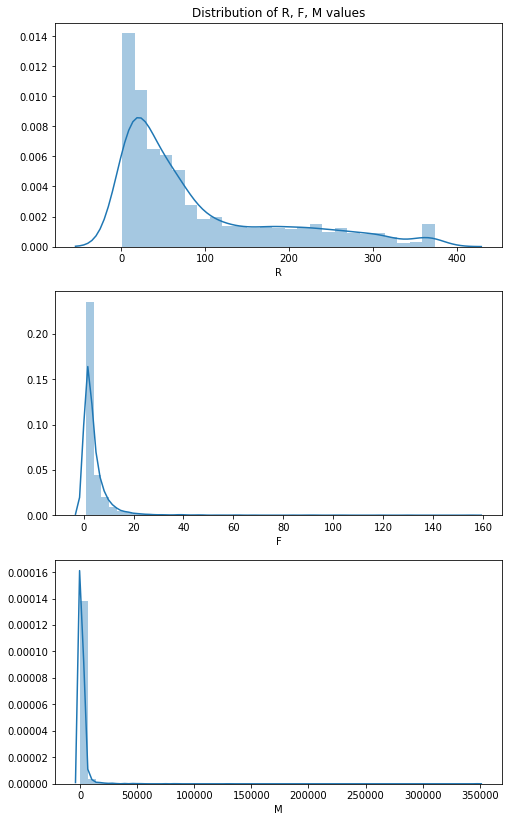

In [42]:
# Exame how the RFM values distributed. The results show that they are skewed
fig = plt.figure(figsize = (8,14))
fig.add_subplot(311)
plt.title('Distribution of R, F, M values')
sns.distplot(df_rfm.R)
fig.add_subplot(312)
sns.distplot(df_rfm.F)
fig.add_subplot(313)
sns.distplot(df_rfm.M)
plt.show()

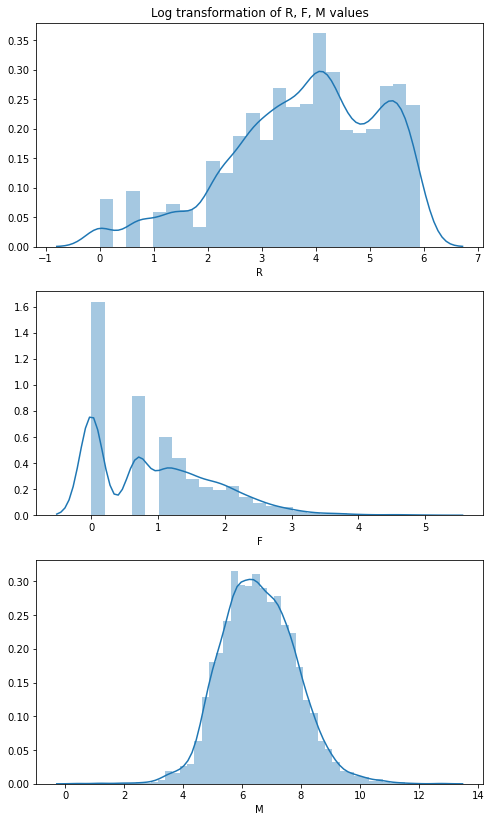

In [43]:
# Conduct log transformation. And check the distribution again
df_rfm_log = np.log(df_rfm)

fig = plt.figure(figsize = (8,14))
fig.add_subplot(311)
plt.title('Log transformation of R, F, M values')
sns.distplot(df_rfm_log.R)
fig.add_subplot(312)
sns.distplot(df_rfm_log.F)
fig.add_subplot(313)
sns.distplot(df_rfm_log.M)
plt.show()

In [44]:
# Normalise values for later clustering
scaler = StandardScaler()
scaler.fit(df_rfm_log)
scaler.transform(df_rfm_log)
rfm_scaled = scaler.transform(df_rfm_log)
df_rfm_scaled = pd.DataFrame(rfm_scaled, index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
Customer ID,,,
12346,0.947772,-0.317141,-1.135506
12608,-0.072387,-1.082610,-0.425042
12745,0.730414,-0.317141,0.013508
12746,0.994234,-1.082610,-0.813186
12747,-1.569397,1.979268,1.544788
...,...,...,...
18283,-0.647241,0.896100,-0.081696
18284,0.298951,-1.082610,-0.342227
18285,1.368497,-1.082610,-0.403997


# Find the suitable K: number of clusters

In [45]:
elbow = {}
sil_score = {}

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state=1)
    kmeans.fit(df_rfm_scaled)
    elbow[i] = kmeans.inertia_
    if i != 1:
        sil_score[i] = silhouette_score(df_rfm_scaled, kmeans.labels_)

Text(0.5, 0, 'number of clusters')

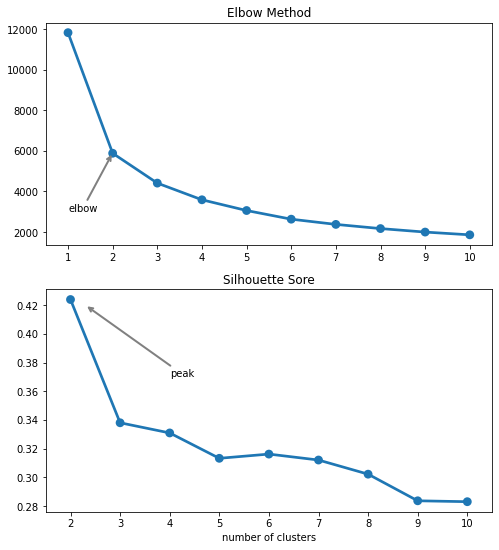

In [46]:
# Compare Elbow Method and Silhouette Score. And it gives the same result - 2 is the optimal number of clusters 
fig = plt.figure(figsize = (8, 9))

fig.add_subplot(211)
plt.title('Elbow Method')
sns.pointplot(list(elbow.keys()), list(elbow.values()))
plt.annotate('elbow', xy=(1, 5900), xytext=(0, 3000), 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='grey', lw=2))

fig.add_subplot(212)
plt.title('Silhouette Sore')
sns.pointplot(list(sil_score.keys()), list(sil_score.values()))
plt.annotate('peak', xy=(0.3, 0.42), xytext=(2, 0.37), 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='grey', lw=2))
plt.xlabel('number of clusters')

# Clustering

In [47]:
# Choose 3 as the number of clusters, right beside the point on elbow
kmeans = KMeans(n_clusters = 3, random_state=1)
kmeans.fit(df_rfm_scaled)
labels = kmeans.labels_
df_rfm = df_rfm.assign(Segments = labels)

In [48]:
# Generate a table of result
summary = df_rfm.groupby('Segments').mean()
overall = df_rfm.mean().tolist()
count = df_rfm.groupby('Segments').count()
summary['Total Customers'] = count.R.to_list()
summary.loc['Overall'] = overall
summary.iloc[3,3] = count.sum(axis=0).R
summary['Total Customers'] = summary['Total Customers'].astype(int)

summary.round(2)

,R,F,M,Total Customers
Segments,,,,
0,14.66,12.39,6061.70,789
1,156.16,1.23,293.14,1582
2,63.33,3.56,1236.53,1571
Overall,90.84,4.40,1823.70,3942


Text(0.5, 0, 'log(M)')

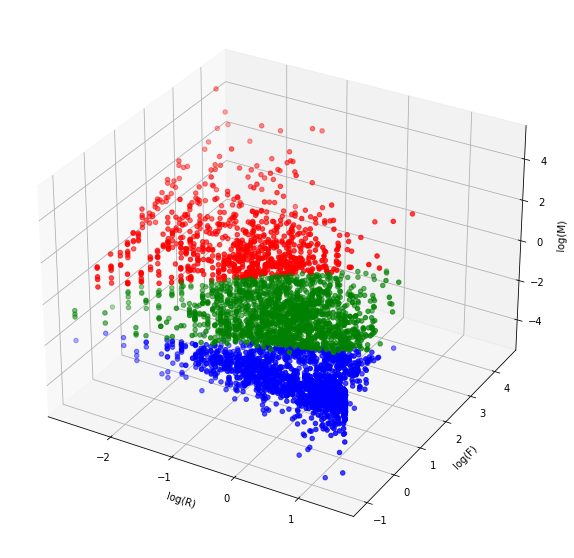

In [49]:
df_rfm_scaled = df_rfm_scaled.assign(Segments = labels)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

segment0 = df_rfm_scaled[df_rfm_scaled.Segments == 0]
segment1 = df_rfm_scaled[df_rfm_scaled.Segments == 1]
segment2 = df_rfm_scaled[df_rfm_scaled.Segments == 2]

ax.scatter(segment0.R, segment0.F, segment0.M, c='red')
ax.scatter(segment1.R, segment1.F, segment1.M, c='blue')
ax.scatter(segment2.R, segment2.F, segment2.M, c='green')

ax.set_xlabel('log(R)')
ax.set_ylabel('log(F)')
ax.set_zlabel('log(M)')